# Introduction
* This notebook contains an analysis of the "House Prices" dataset from kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques.
* The goal of the competition is to train a model that gets the lowest Root-Mean-Squared-Error between the logarithm of the predicted value (for the test data provided by kaggle) and the logarithm of the observed sales price (taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally).

#### The notebook is divided into the following parts:
* [Part 1: Notebook Preparation](#part_1)
* [Part 2: Data Exploration](#part_2)
* [Part 3: Feature Engineering](#part_3)
* [Part 4: Feature Analysis](#part_4)
* [Part 5: Modeling](#part_5)
* [Part 6: Make Prediction for the Test Data](#part_6)

#### The prediction that I submitted to kaggle got a score of ~0.13

<a id='part_1'></a>
# Part 1: Notebook Preparation

## Import

In [1]:
# Data analysis
import pandas as pd
import numpy as np
from scipy.stats import skew, norm, probplot, boxcox

# Visualization
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import HuberRegressor, BayesianRidge, ElasticNet, LinearRegression, PassiveAggressiveRegressor, RANSACRegressor, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
    
%autosave 60

Autosaving every 60 seconds


## Config

In [2]:
trainFileName = 'train.csv'
testFileName = 'test.csv'
TARGET_COLUMN = 'SalePrice'

## Functions

In [3]:
def get_distribution_and_QQ_plot_of_a_column(columnName, column):
    fig = plt.figure(figsize=(12,4))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(column)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(column, fit=norm)
    fig1.set_title('Distribution (mu = {:.2f} and sigma = {:.2f})'.format(mu, sigma), loc='center')
    fig1.set_xlabel(columnName)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(column, plot=fig2)
    fig2.set_title('Probability Plot (skewness: {:.6f} and kurtosis: {:.6f})'.\
                   format(column.skew(), column.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

In [4]:
def get_odds_ratio_list(CLASS_LABEL, columnToCheck, Table):
    """
    Returns list with:
        oddsRatio,
        likelihoodRatio,
        and the number of rows with: 
            feature = 1 & label = 1,
            feature = 1 & label = 0,
            feature = 0 & label = 1,
            feature = 0 & label = 0,
            total rows with feature = 1.
    params:
        CLASS_LABEL - the column to check lift for (contains only 1/0/None)
        columnToCheck - the features we want to check (contains only 1/0/None)
        Table - the table with all the rows with 2 columns, 1 for the CLASS_LABEL column and 1 for the columnToCheck
    """
    table = Table[[CLASS_LABEL, columnToCheck]]
    table = table.reset_index()
    pivot = table.pivot_table("index", index=CLASS_LABEL, columns=columnToCheck, aggfunc=len)
    pivot = pivot.fillna(0).astype('float')
    if len(pivot) == 2:
        if list(pivot.columns) == [1]:
            pivot[0] = [0,0]
        elif list(pivot.columns) == [0]:
            pivot[1] = [0,0]
    if len(list(pivot.columns)) == 2:
        if list(pivot.index) == [1]:
            pivot.loc[0] = [0,0]
        elif list(pivot.index) == [0]:
            pivot.loc[1] = [0,0]
    if pivot.shape == (2,2):
        A = pivot[1][1]
        B = pivot[0][1]
        C = pivot[1][0]
        D = pivot[0][0]
        if (B>0) & (C>0) & (D>0):
            likelihoodRatio = (A/(A+B))/(C/(C+D))
            oddsRatio = (A/B)/(C/D)
            return [oddsRatio, likelihoodRatio, A, C, B, D, A+C]
    return [None, None, None, None, None, None, None]

In [5]:
def make_lifts_report_based_on_filters_of_features(df, columnsToCheck, CLASS_LABEL):
    """
    Returns pandas df with lifts report per feature in the list columnsToCheck.
    params:
        df - the df with all the rows and the binary features (as columns) and the class label column.
        columnsToCheck - all the features that need to be checked (one at a time).
        CLASS_LABEL - the column to check lift for.
    """
    oddsRatioDF = pd.DataFrame()
    for column in columnsToCheck:
        oddsRatioDF[column] = get_odds_ratio_list(CLASS_LABEL, column, df)
    oddsRatioDF = oddsRatioDF.T
    oddsRatioDF.columns = ['oddsRatio',\
                           'likelihoodRatio',\
                           'Feature=1_Label=1',\
                           'Feature=1_Label=0',\
                           'Feature=0_Label=1',\
                           'Feature=0_Label=0',\
                           'total_Feature=1']
    return oddsRatioDF

In [6]:
def get_bar_plot(df, column, CLASS_LABEL, q=20):

    df = df[~pd.isna(df[column])]
    binsDf = pd.DataFrame(pd.qcut(df[column], q=q, duplicates='drop').apply(lambda x: x.right))
    binsDf[CLASS_LABEL] = list(df[CLASS_LABEL])

    data = binsDf.groupby(column).agg({CLASS_LABEL: 'mean', column: 'count'})
    
    if len(data) <= 1: # There is not enough data for a graph
        return
    
    data.columns = ['mean','count']

    sns.barplot(data.index, data['mean'])
    fig = plt.gcf()
    fig.set_size_inches(15,5)
    plt.xticks(rotation=70)

    plt.show()

In [7]:
def rmse(y_true, y_pred):
    
    min_value = np.min(y_true)
    # make sure there are no negative values
    y_true = [i if i>0 else min_value for i in y_true]
    y_pred = [i if i>0 else min_value for i in y_pred]
    
    # calculate the error
    error = np.sqrt(mean_squared_error(np.log(y_true),np.log(y_pred)))

    return error

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [8]:
def plot_feature_importance(X_test, y_test, fit): 

    assert hasattr(fit, 'feature_importances_'), 'No feature importance attribute in the fit'
        
    impDf = pd.DataFrame(list(zip(X_test.columns, fit.feature_importances_)), columns=['feature', 'imp'])\
    .sort_values('imp', ascending=False)

    sns.barplot(x='imp', y='feature', data=impDf.iloc[:25])
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.title('Feature importance')
    plt.show()

<a id='part_2'></a>
# Part 2: Data Exploration

##### Conclusions based on the data exploration:
* The target column distribution is not normal - that needs to be fixed.
* In the dataset there are 80 features (excluding the id and the target), 36 of them are numerical features and the rest are categorical.
* There are a lot of features with nulls or zeros - that needs to be fixed and cleaned.
* The are a little bit of mismatches in the columns that contain years, for example a house that was sold before it was built. I suspect there is data leakage in these cases. Because there are just a few such cases, I chose to ignore these lines and leave them.
* There is one line that contains the year 2207 - that's obviously a typo, so I fixed it to 2007 (which is also the year that this house was sold and remodeled and added a garage).

In [9]:
# Train
df_train = pd.read_csv(trainFileName).set_index('Id')
X_train = df_train[~pd.isna(df_train[TARGET_COLUMN])]
if TARGET_COLUMN in X_train.columns:
    X_train = X_train.drop(TARGET_COLUMN, 1)
y_train = df_train[TARGET_COLUMN][~pd.isna(df_train[TARGET_COLUMN])]

# Test
X_test = pd.read_csv(testFileName).set_index('Id')

In [10]:
# Combine them to build all features all at once
X_train['isTest'] = 0
X_test['isTest'] = 1

X_full = pd.concat([X_train,X_test])

In [11]:
X_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,isTest
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,0


## Make the distribution of the target column normal

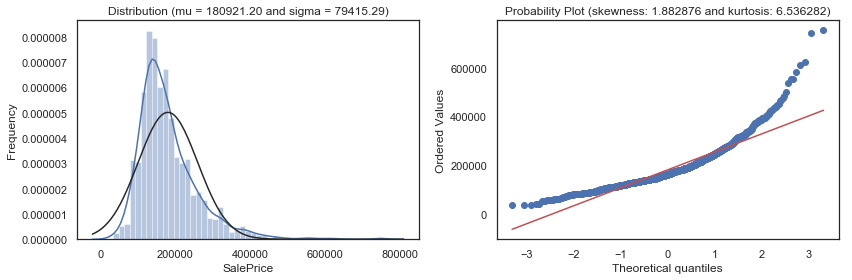

In [12]:
get_distribution_and_QQ_plot_of_a_column(TARGET_COLUMN, y_train)

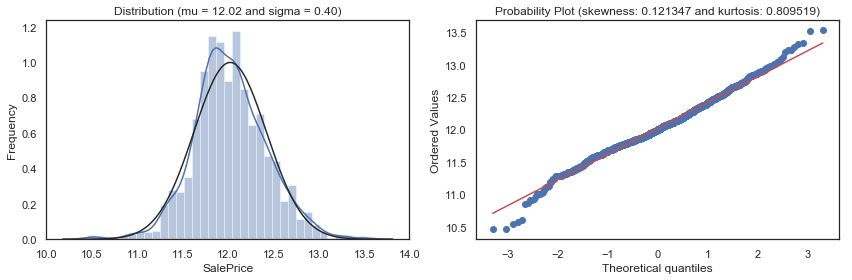

In [13]:
y_train_orig = y_train.copy()
y_train = np.log1p(y_train)
get_distribution_and_QQ_plot_of_a_column(TARGET_COLUMN, y_train)

## Check which columns are numeric and if there are nulls and zeros

In [14]:
numericTypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numericFeatures = list(X_full.select_dtypes(include=numericTypes).columns)
numericFeatures.remove('isTest')

print(f'There are {len(numericFeatures)} numeric features')

There are 36 numeric features


In [15]:
columnsDf = pd.DataFrame({'column name': list(X_full.columns)})
columnsDf['numeric'] = columnsDf['column name'].apply(lambda column: int(column in numericFeatures))
columnsDf['% of nulls'] = columnsDf['column name'].apply(lambda column: len(X_full[pd.isna(X_full[column])]) / len(X_full) * 100)
columnsDf['% of zeroz'] = columnsDf['column name'].apply(lambda column: len(X_full[X_full[column] == 0]) / len(X_full) * 100)
columnsDf['# unique values'] = columnsDf.apply(lambda row: len(X_full[row['column name']].unique()) if row['numeric'] == 0 else None ,axis=1)
columnsDf['min value'] = columnsDf.apply(lambda row: X_full[row['column name']].min() if row['numeric'] == 1 else None ,axis=1)
columnsDf['max value'] = columnsDf.apply(lambda row: X_full[row['column name']].max() if row['numeric'] == 1 else None ,axis=1)

In [16]:
# Numeric columns
columnsDf[(columnsDf['numeric'] == 1)]

,column name,numeric,% of nulls,% of zeroz,# unique values,min value,max value
0,MSSubClass,1,0.000000,0.000000,NaN,20.0,190.0
2,LotFrontage,1,16.649538,0.000000,NaN,21.0,313.0
3,LotArea,1,0.000000,0.000000,NaN,1300.0,215245.0
16,OverallQual,1,0.000000,0.000000,NaN,1.0,10.0
17,OverallCond,1,0.000000,0.000000,NaN,1.0,9.0
18,YearBuilt,1,0.000000,0.000000,NaN,1872.0,2010.0
19,YearRemodAdd,1,0.000000,0.000000,NaN,1950.0,2010.0
25,MasVnrArea,1,0.787941,59.540939,NaN,0.0,1600.0
33,BsmtFinSF1,1,0.034258,31.825968,NaN,0.0,5644.0
35,BsmtFinSF2,1,0.034258,88.078109,NaN,0.0,1526.0


In [17]:
# Categorical columns
columnsDf[(columnsDf['numeric'] == 0)]

,column name,numeric,% of nulls,% of zeroz,# unique values,min value,max value
1,MSZoning,0,0.137033,0.000000,6.0,NaN,NaN
4,Street,0,0.000000,0.000000,2.0,NaN,NaN
5,Alley,0,93.216855,0.000000,3.0,NaN,NaN
6,LotShape,0,0.000000,0.000000,4.0,NaN,NaN
7,LandContour,0,0.000000,0.000000,4.0,NaN,NaN
8,Utilities,0,0.068517,0.000000,3.0,NaN,NaN
9,LotConfig,0,0.000000,0.000000,5.0,NaN,NaN
10,LandSlope,0,0.000000,0.000000,3.0,NaN,NaN
11,Neighborhood,0,0.000000,0.000000,25.0,NaN,NaN
12,Condition1,0,0.000000,0.000000,9.0,NaN,NaN


## Data validation

* I thought that all the data on the houses should be from before the sale, because otherwise there is data leakage. 
* There are very few lines where this is not the case, so I chose to ignore it. 
* I hope there are no cases of data leakage that I can not check for.

In [18]:
# Are there any houses that were sold before they were built, remodeled or before the garage was built?
X_full[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']][(X_full['YrSold'] < X_full['YearBuilt']) | 
                                                            (X_full['YrSold'] < X_full['YearRemodAdd']) | 
                                                            (X_full['YrSold'] < X_full['GarageYrBlt'])]

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
Id,,,,
524,2007,2008,2007.0,2007
2296,2007,2008,2007.0,2007
2550,2008,2009,2008.0,2007
2593,2006,2007,2207.0,2007


In [19]:
# Fix the typo year 2207 of the year that the garage was built to 2007
X_full.loc[2593,'GarageYrBlt'] = 2007

<a id='part_3'></a>
# Part 3: Feature Engineering

## Fill nulls

In [20]:
# Fillna on the numeric columns

# The house has no garage
columnsToFillna = ['GarageYrBlt','GarageArea','GarageCars']
for column in columnsToFillna:
    X_full[column] = X_full[column].fillna(0)
    
# The house has no basement
columnsToFillna = ['BsmtFinSF1','BsmtFinSF2','BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF','TotalBsmtSF']
for column in columnsToFillna:
    X_full[column] = X_full[column].fillna(0)

# The house has no MasVnrArea
X_full['MasVnrArea'] = X_full['MasVnrArea'].fillna(0)

# It doesn't make sense that the house doesn't have frontage, so I will fill it with the median value per neighborhood
X_full["LotFrontage"] = X_full.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [21]:
# Fillna on the categorical columns

# The house has no garage
columnsToFillna = ['GarageType','GarageFinish','GarageQual', 'GarageCond']
for column in columnsToFillna:
    X_full[column] = X_full[column].fillna("None")

# The house has no basement
columnsToFillna = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for column in columnsToFillna:
    X_full[column] = X_full[column].fillna("None")
    
# The house has no pool / fireplace / fence / MiscFeature / Alley / MasVn / Utilities / Exteriors
columnsToFillna = ['Fence','PoolQC','FireplaceQu', 'MiscFeature', 'Alley', "MasVnrType", 'Utilities', 'Exterior1st', 'Exterior2nd']
for column in columnsToFillna:
    X_full[column] = X_full[column].fillna("None")

# Fill with the most common value, because I don't think that the house doesn't have these things
columnsToFillna = ['MSZoning','Electrical','KitchenQual','Functional','SaleType']
for column in columnsToFillna:
    X_full[column] = X_full[column].fillna(X_full[column].mode()[0])

In [22]:
# Check if there are more nulls
columnsWithNulls = []
for column in X_full.columns:
    if len(X_full[pd.isna(X_full[column])]) > 0:
        columnsWithNulls.append(column)

print(f'Number of columns with null values: {len(columnsWithNulls)}')

Number of columns with null values: 0


## Add Features

### Add binary features

In [23]:
X_full['has_Pool'] = (X_full['PoolArea'] > 0).astype(int)
X_full['has_Fireplace'] = (X_full['Fireplaces'] > 0).astype(int)
X_full['has_Garage'] = (X_full['GarageArea'] > 0).astype(int)
X_full['has_Basement'] = (X_full['TotalBsmtSF'] > 0).astype(int)
X_full['has_FullBath'] = (X_full['BsmtFullBath'] > 0).astype(int)
X_full['has_HalfBath'] = (X_full['BsmtHalfBath'] > 0).astype(int)
X_full['has_2ndFloor'] = (X_full['2ndFlrSF'] > 0).astype(int)
X_full['has_OpenPorch'] = (X_full['OpenPorchSF'] > 0).astype(int)
X_full['has_ScreenPorch'] = (X_full['ScreenPorch'] > 0).astype(int)
X_full['has_EnclosedPorch'] = (X_full['EnclosedPorch'] > 0).astype(int)
X_full['has_3SsnPorch'] = (X_full['3SsnPorch'] > 0).astype(int)
X_full['has_WoodDeck'] = (X_full['WoodDeckSF'] > 0).astype(int)

X_full['has_Alley'] = (X_full['Alley'] == "None").astype(int)
X_full['has_Fence'] = (X_full['Fence'] == "None").astype(int)
X_full['has_Exterior'] = (X_full['Exterior1st'] == "None").astype(int)
X_full['has_MasVnr'] = (X_full['MasVnrType'] == "None").astype(int)
X_full['has_MiscFeature'] = (X_full['MiscFeature'] == "None").astype(int)
X_full['has_Utilities'] = (X_full['Utilities'] == "None").astype(int)

X_full['is_New'] = (X_full['YearBuilt'] == X_full['YrSold']).astype(int)
X_full['ever_Remodeled'] = (X_full['YearBuilt'] != X_full['YearRemodAdd']).astype(int)
X_full['just_Remodeled'] = (X_full['YrSold'] == X_full['YearRemodAdd']).astype(int)

binaryFeatures = ['has_Pool','has_Fireplace','has_Garage','has_Basement','has_FullBath',
                  'has_HalfBath','has_2ndFloor','has_OpenPorch','has_ScreenPorch',
                  'has_EnclosedPorch','has_3SsnPorch','has_WoodDeck','has_Alley','has_Fence',
                  'has_Exterior','has_MasVnr','has_MiscFeature','has_Utilities', 
                  'is_New', 'ever_Remodeled', 'just_Remodeled']

### Add continuous features

In [24]:
X_full['total_SF'] = X_full['TotalBsmtSF'] + X_full['1stFlrSF'] + X_full['2ndFlrSF']
X_full['total_baths'] = X_full['FullBath'] + X_full['BsmtFullBath'] + 0.5*(X_full['HalfBath'] + X_full['BsmtHalfBath'])
X_full['house_age'] = X_full['YrSold'] - X_full['YearBuilt']
X_full['total_Porch_SF'] = X_full['OpenPorchSF'] + X_full['EnclosedPorch'] + X_full['3SsnPorch'] + X_full['ScreenPorch'] + X_full['WoodDeckSF']

# Add the features 'price_per_SF_per_neighborhood' and 'price_per_SF_per_neighborhood * total_SF'
df_train = X_full[X_full['isTest'] == 0].copy()
df_train[TARGET_COLUMN] = y_train_orig
df_train['price_per_SF'] = df_train[TARGET_COLUMN] / df_train['total_SF']
df_train['price_per_SF_per_neighborhood'] = df_train.groupby("Neighborhood")['price_per_SF'].transform('mean')
neighborhoodToPricePerSfDf = df_train[['Neighborhood', 'price_per_SF_per_neighborhood']].drop_duplicates()

X_full = X_full.reset_index().merge(neighborhoodToPricePerSfDf, on='Neighborhood', how='left').set_index('Id')
X_full['price_per_SF_per_neighborhood * total_SF'] = X_full['price_per_SF_per_neighborhood'] * X_full['total_SF']

numericFeatures += ['total_SF','total_baths','house_age', 'total_Porch_SF',
                    'price_per_SF_per_neighborhood', 'price_per_SF_per_neighborhood * total_SF']

### Add one hot encoding features
* Because all the categorical features have maximum 25 unique values each, I chose to do one hot encoding for all of them.

In [25]:
categoricalFeatures = list(set(X_full.columns) - set(numericFeatures) - set(binaryFeatures) - {'isTest'})

In [26]:
# Add columns that contain the existence of each categorical feature as 0 or 1 (using get_dummies).
dfGetDummies = pd.get_dummies(X_full[categoricalFeatures].astype(str))
dummiesFeatures = [feature for feature in dfGetDummies.columns if 'None' not in feature]
X_full = X_full.merge(dfGetDummies[dummiesFeatures], left_index=True, right_index=True,how='left')
dummiesFeatures += binaryFeatures

<a id='part_4'></a>
# Part 4: Feature Analysis

In [27]:
df_train = X_full[X_full['isTest'] == 0].copy()
df_train[TARGET_COLUMN] = y_train_orig
df_train.index.name = None

## Trends
* From my experience, a strong continuous feature is in most cases monotonic. That is why I check for trends of the continuous features, using this kind of bar plot.
* As can be seen in the plot below, there are a lot of features that are very indicative to the target.
* Examples for features that are indicative to the target and have a clear trend:
    * The feature "price_per_SF_per_neighborhood * total_SF" seems to be very good - the higher it is, the higher the price of the house.
    * The feature "house_age" - the lower it is the higher the price of the house.
    * The features "total_baths" and "total_SF" - the higher they are, the higher the price of the house.
* Examples for features that do not have a clear trend: YrSold, MoSold, MSSubClass

MSSubClass


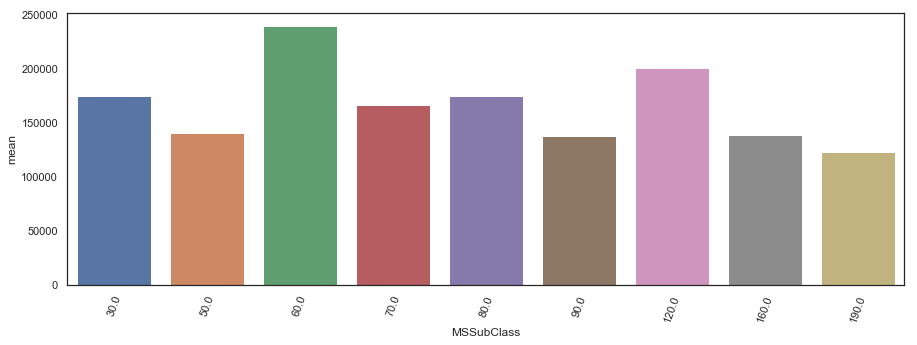

LotFrontage


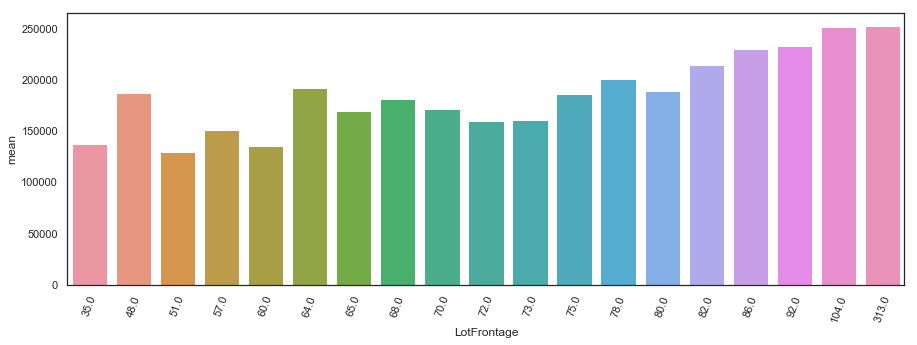

LotArea


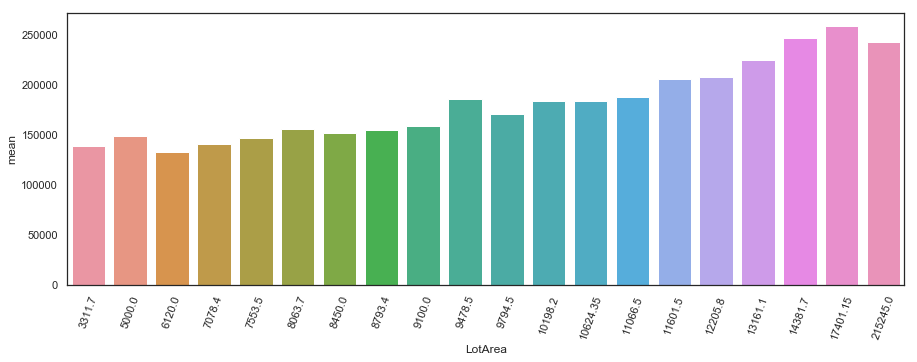

OverallQual


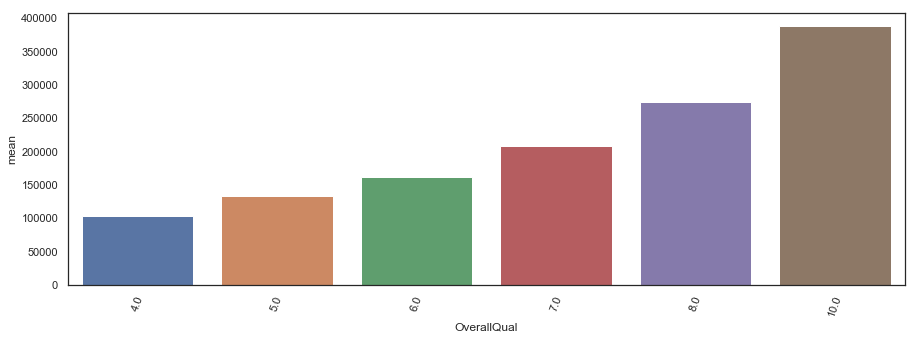

OverallCond


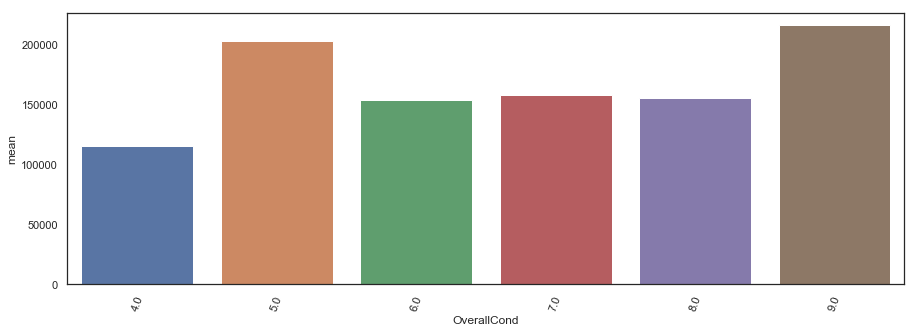

YearBuilt


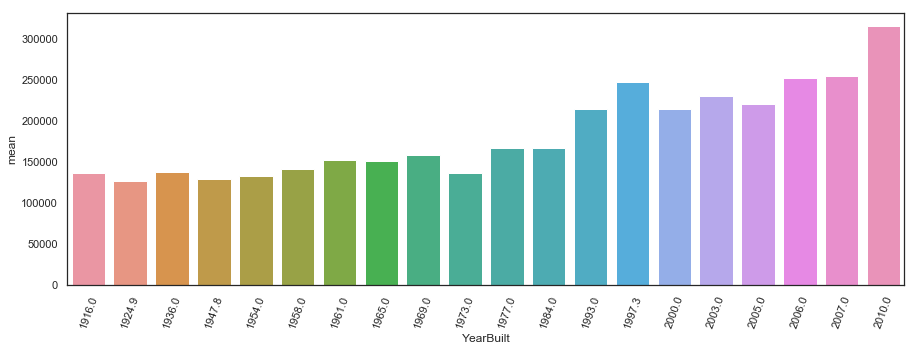

YearRemodAdd


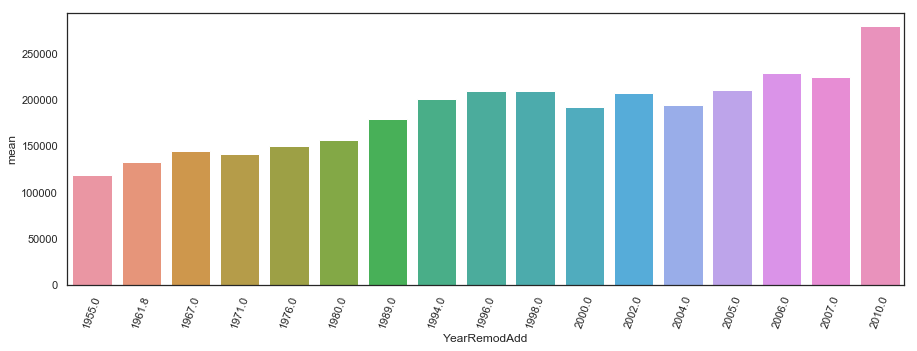

MasVnrArea


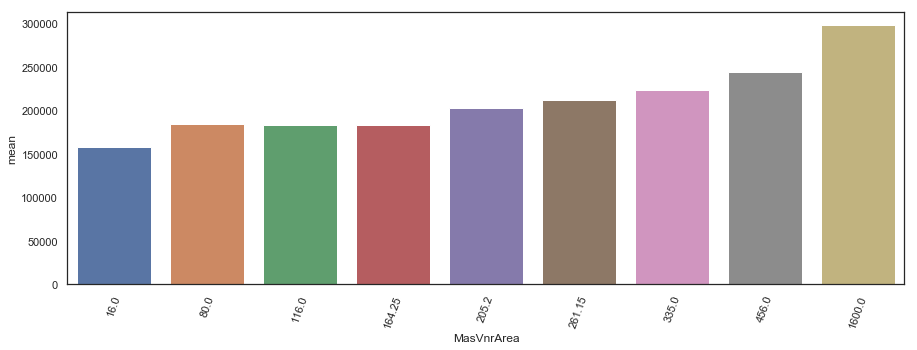

BsmtFinSF1


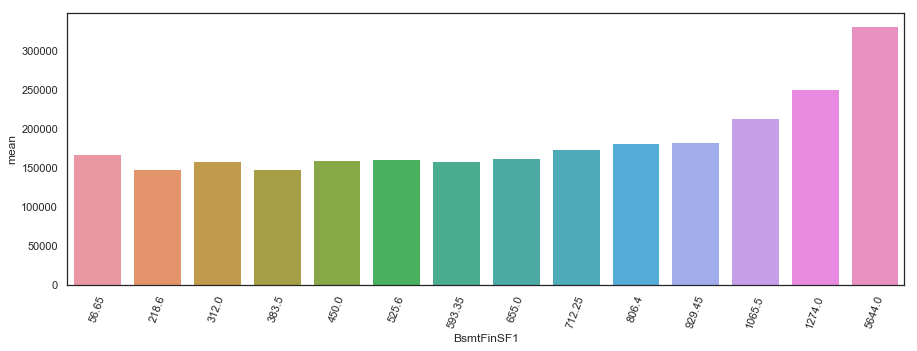

BsmtFinSF2


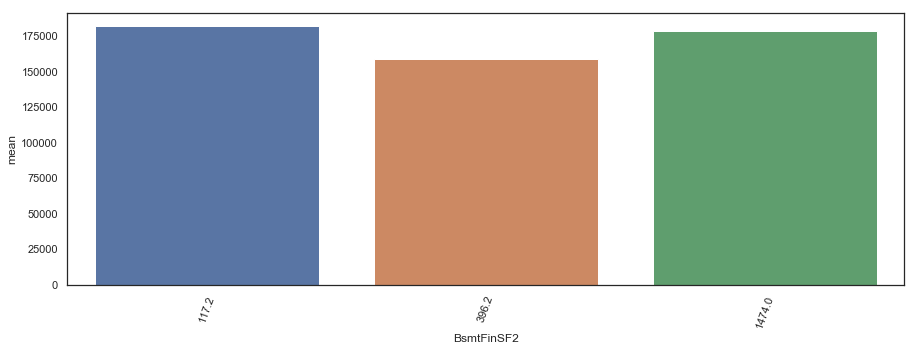

BsmtUnfSF


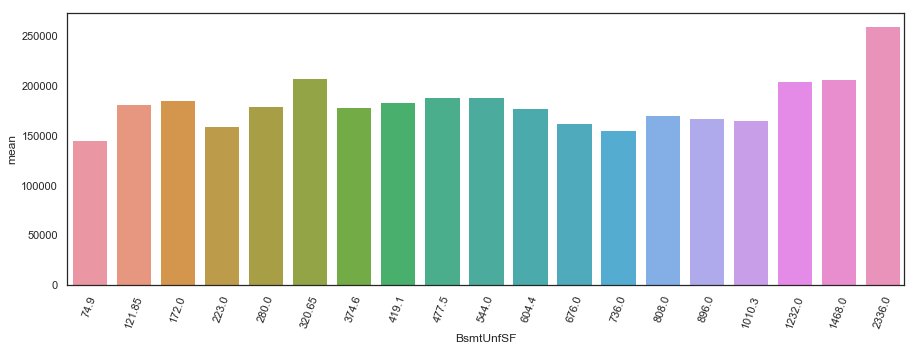

TotalBsmtSF


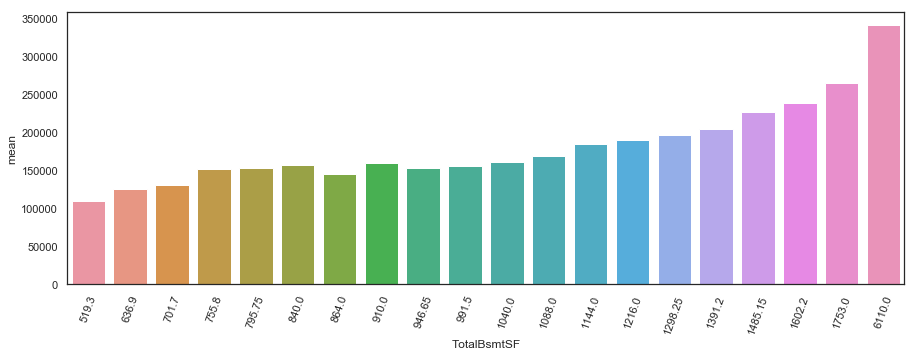

1stFlrSF


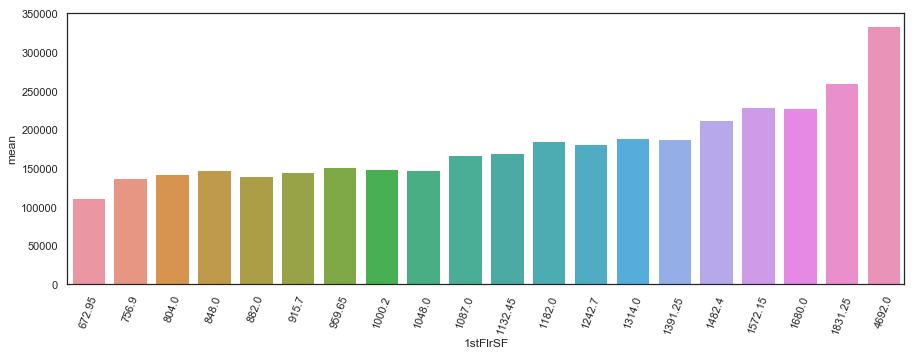

2ndFlrSF


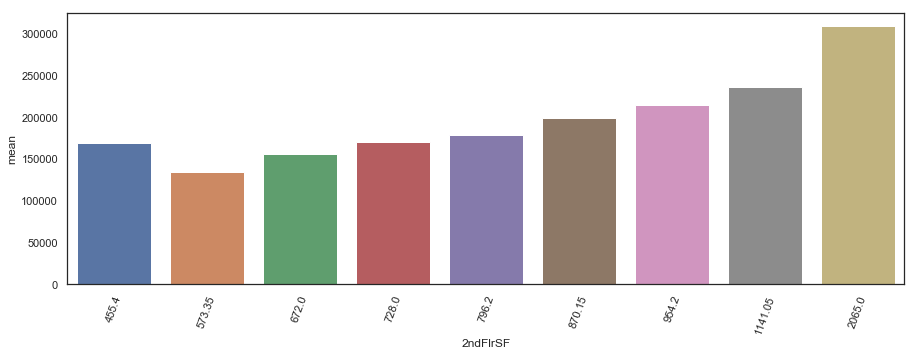

LowQualFinSF
GrLivArea


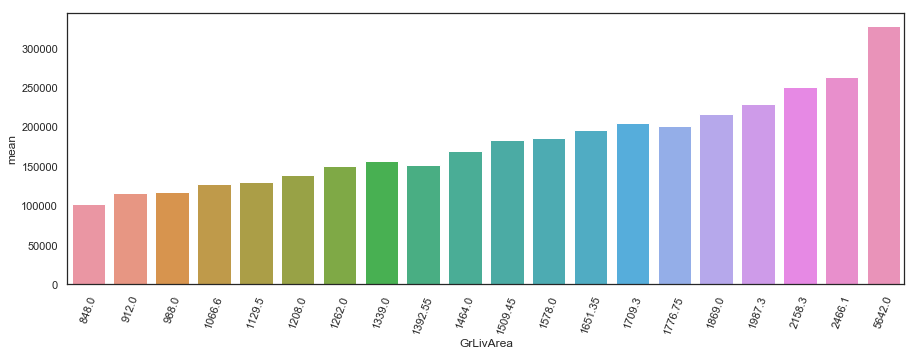

BsmtFullBath


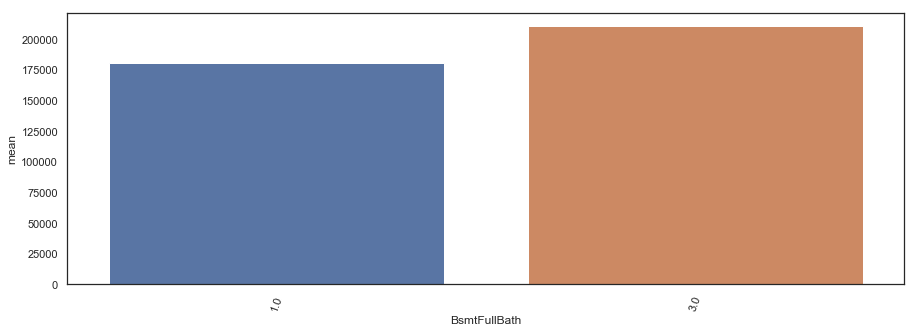

BsmtHalfBath


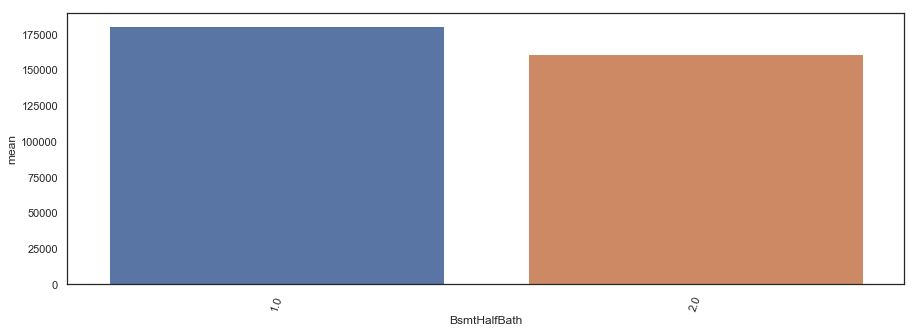

FullBath


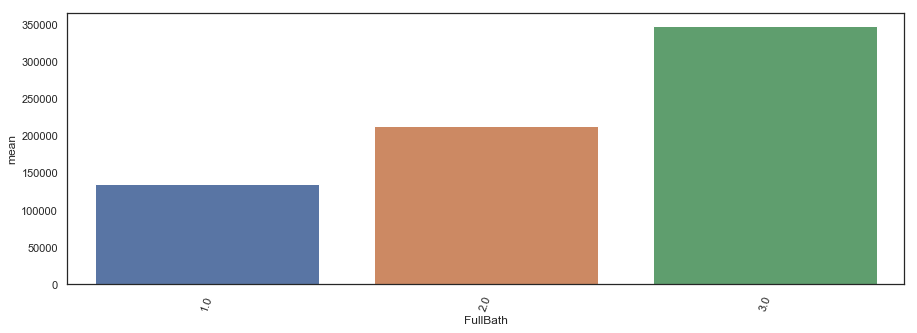

HalfBath


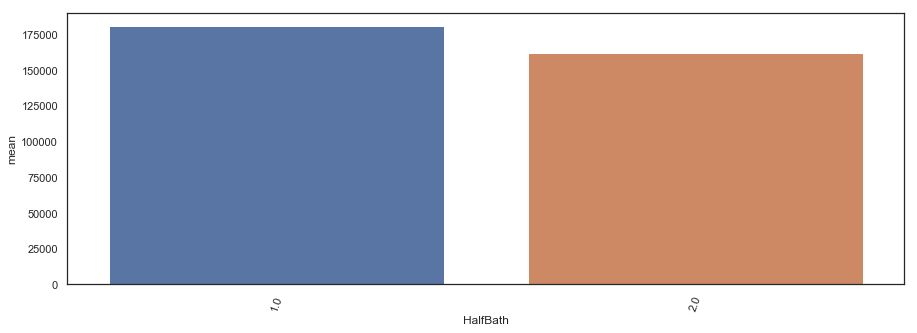

BedroomAbvGr


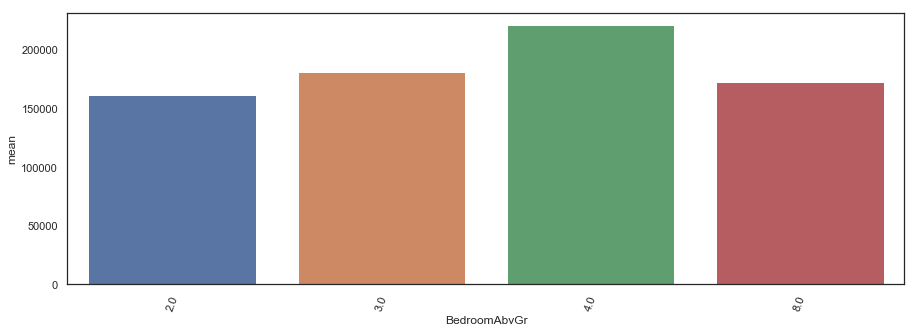

KitchenAbvGr


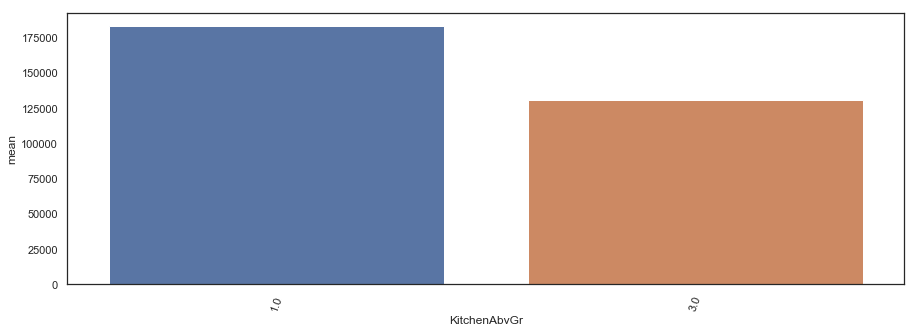

TotRmsAbvGrd


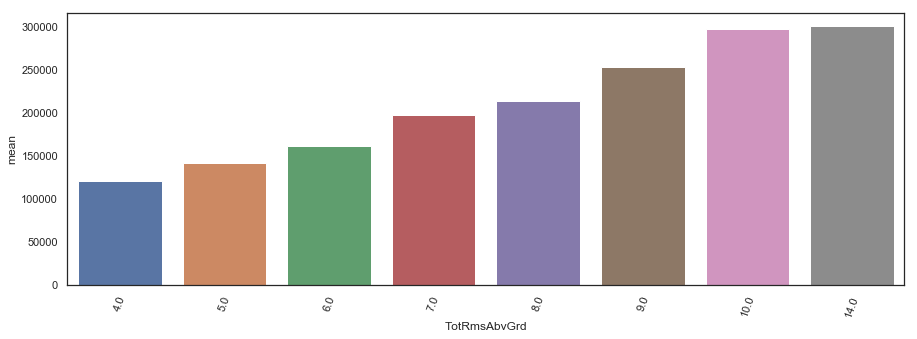

Fireplaces


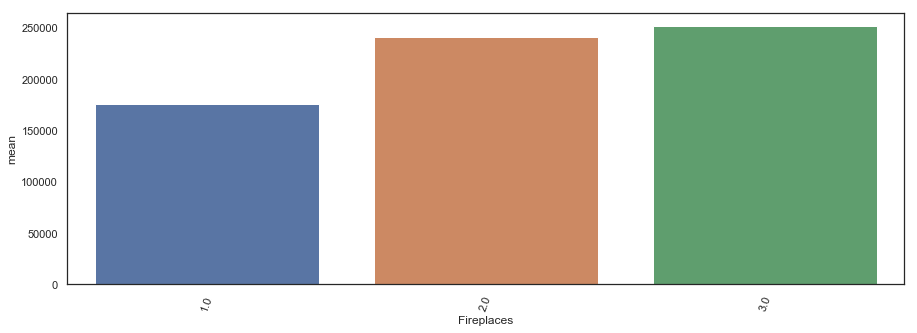

GarageYrBlt


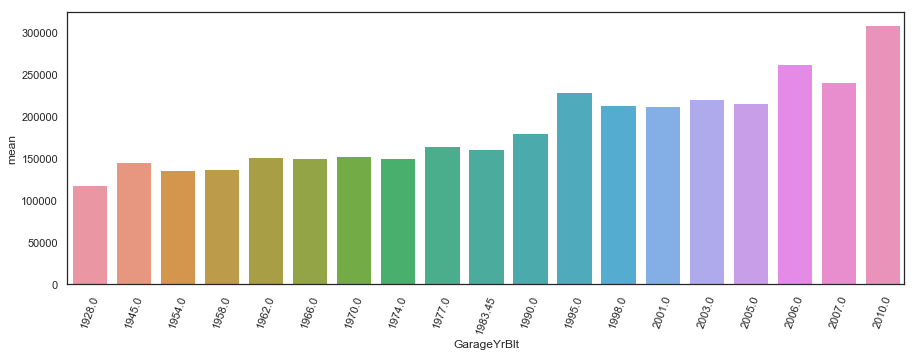

GarageCars


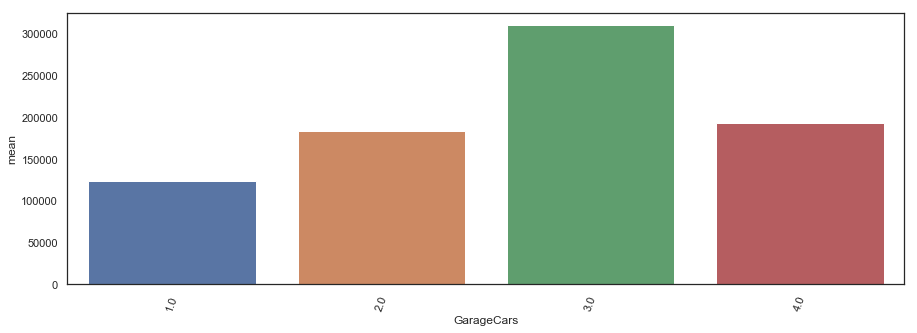

GarageArea


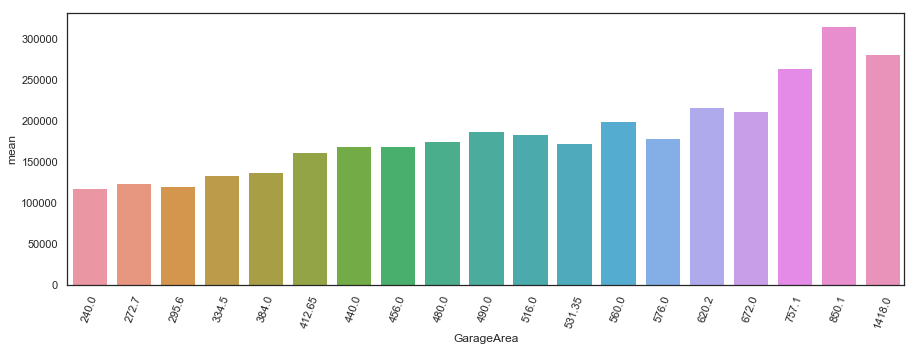

WoodDeckSF


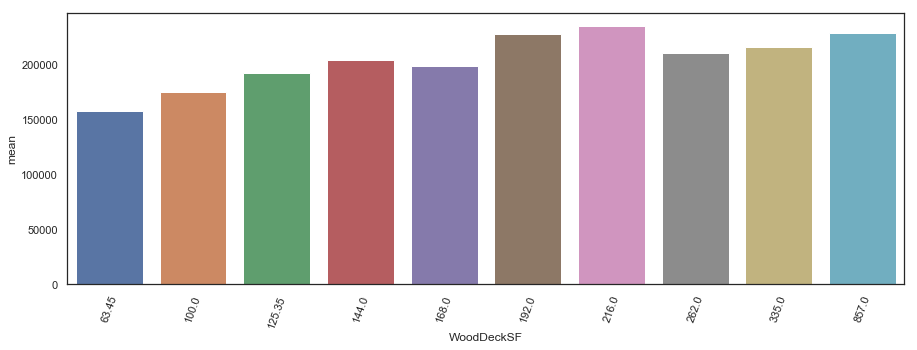

OpenPorchSF


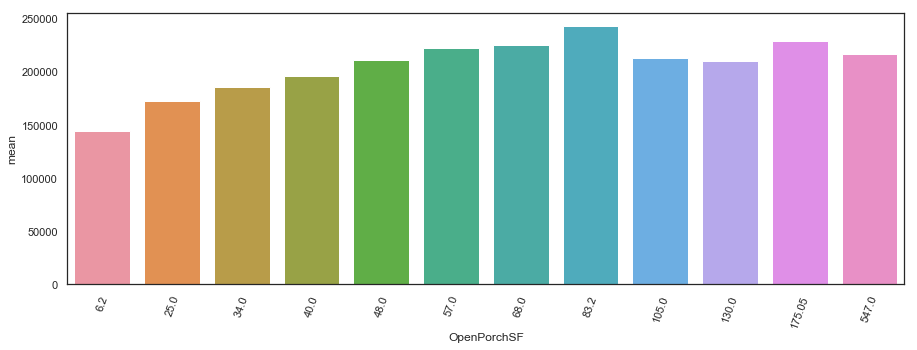

EnclosedPorch


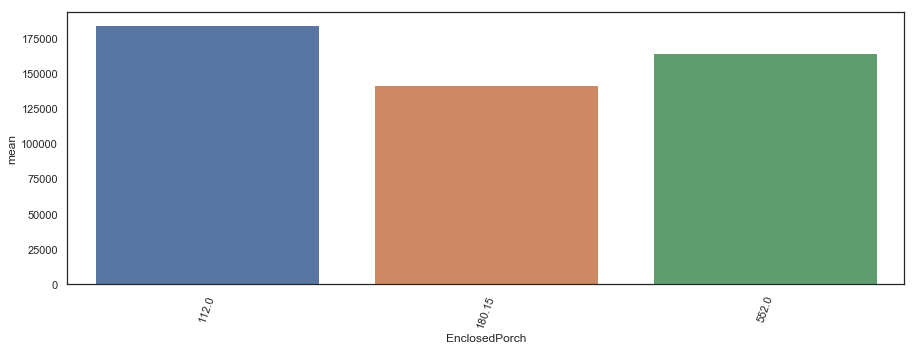

3SsnPorch
ScreenPorch


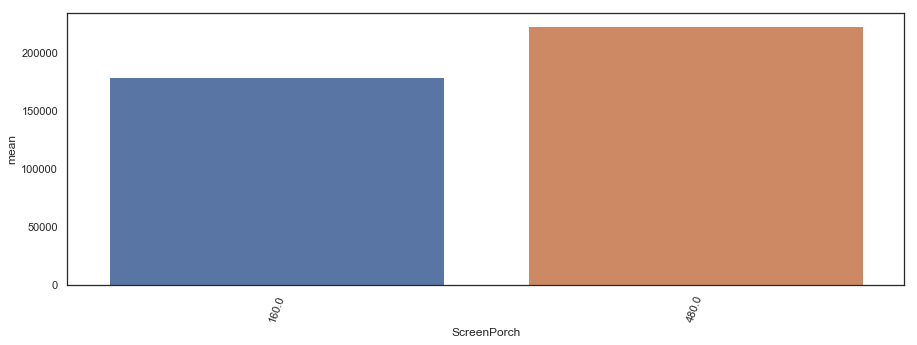

PoolArea
MiscVal
MoSold


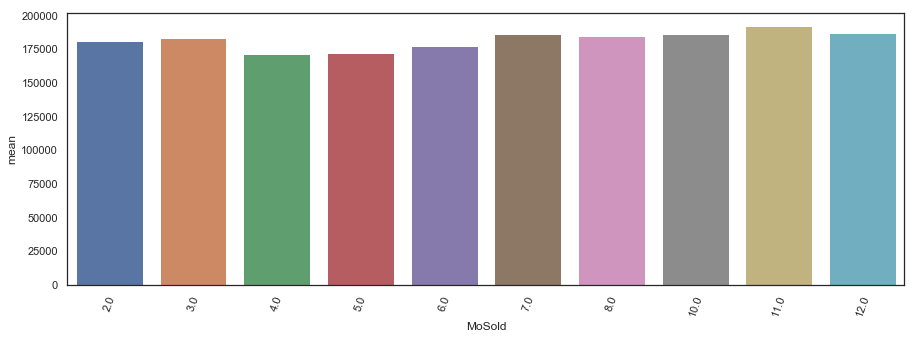

YrSold


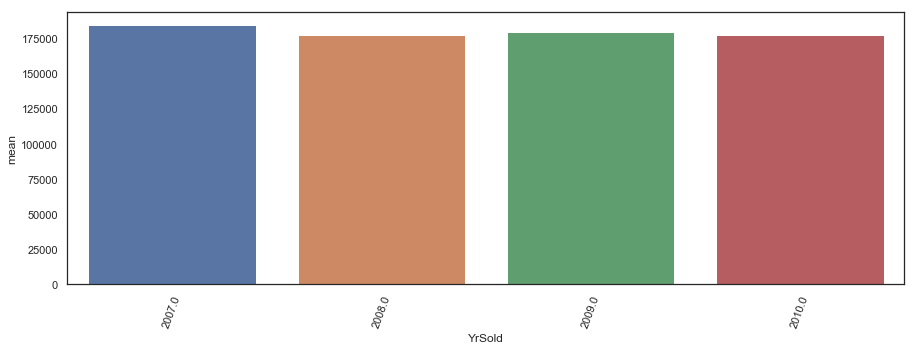

total_SF


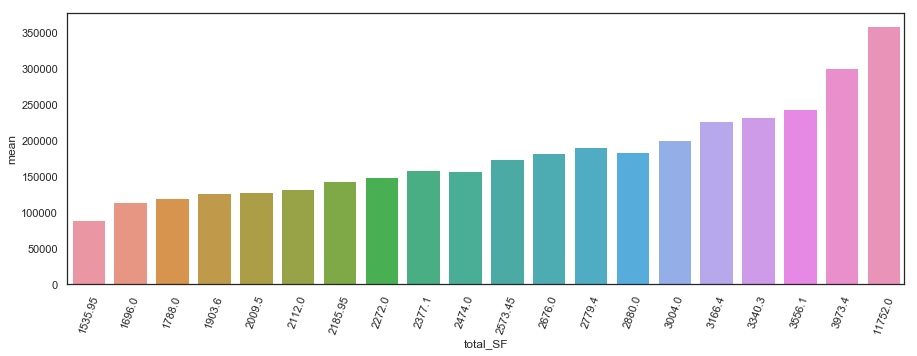

total_baths


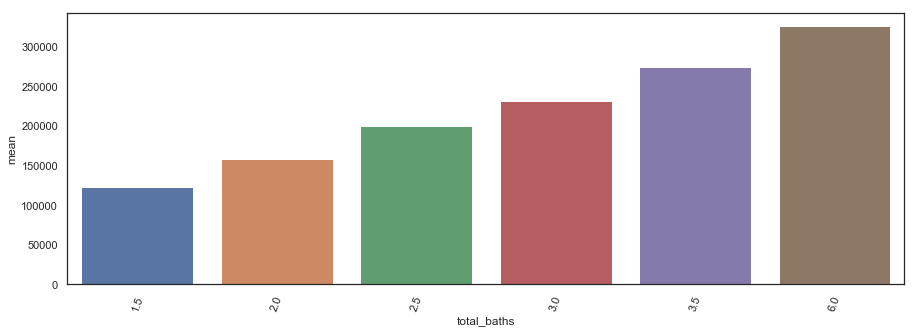

house_age


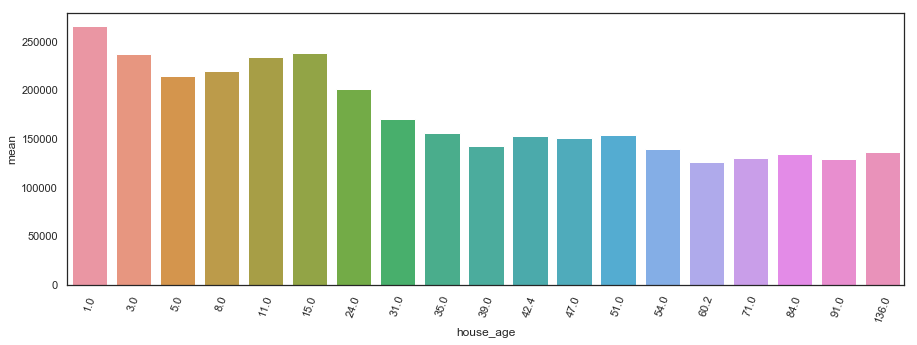

total_Porch_SF


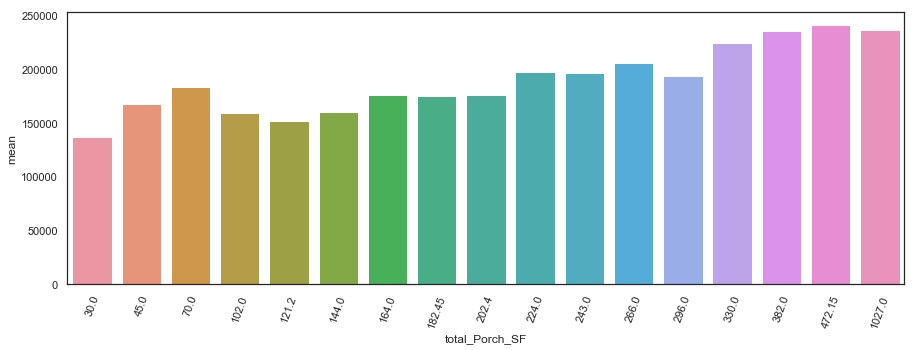

price_per_SF_per_neighborhood


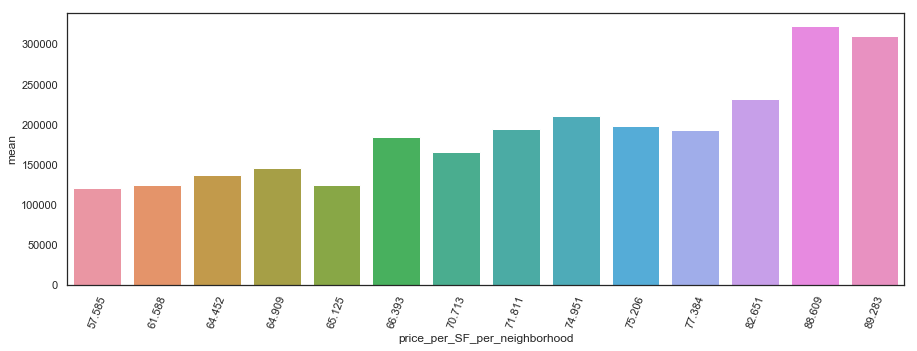

price_per_SF_per_neighborhood * total_SF


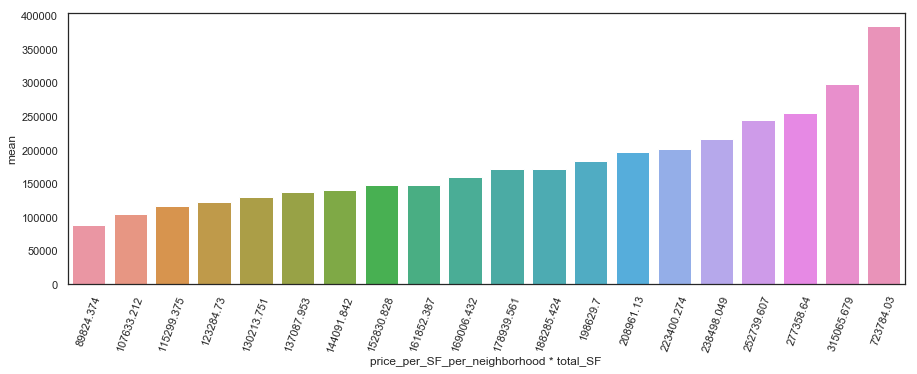

In [28]:
for feature in numericFeatures:
    print(feature)
    get_bar_plot(df_train, feature, TARGET_COLUMN, q=20)

## Lifts
* To get a sense of the data, I like to take a look at the lifts of the binary features to the upper median of the target (or another fraction), as it is a binary classification problem, while class 1 is the upper median of the target column and class 0 is the lower median of the target column.
* Examples for what I can learn from that kind of report:
    * Houses in the neighborhoods NridgHt, Gilbert and Somerst are more likely to be expensive.
    * Houses in the neighborhoods OldTown, Sawyer, BrkSide and Edwards are less likely to be expensive.
    * New houses (that sold in the same year they were built) are more likely to be expensive.
    * Quality of type "EX" (Excellent) on the categorical features "ExterQual", "BamtQual" and "KitchenQual" is the most expensive quality type, and houses with that quality type are more likely to be expensive.

In [29]:
df_train[TARGET_COLUMN+'_upper_median'] = (df_train[TARGET_COLUMN] >= df_train[TARGET_COLUMN].median()).astype(int)

In [30]:
liftsDf = make_lifts_report_based_on_filters_of_features(df_train, dummiesFeatures, TARGET_COLUMN+'_upper_median')
minimum_support = liftsDf['total_Feature=1'].median()
liftsDf_filtered = liftsDf[liftsDf['total_Feature=1']>=minimum_support]

In [31]:
print('Top 15 categories:')
display(liftsDf_filtered.sort_values(by='likelihoodRatio', ascending=False).iloc[:15])
print('Bottom 15 categories:')
display(liftsDf_filtered.sort_values(by='likelihoodRatio', ascending=True).iloc[:15])

Top 15 categories:


,oddsRatio,likelihoodRatio,Feature=1_Label=1,Feature=1_Label=0,Feature=0_Label=1,Feature=0_Label=0,total_Feature=1
Neighborhood_NridgHt,84.2256,75.5847,76,1,656,727,77
ExterQual_Ex,54.4449,50.7213,51,1,681,727,52
is_New,21.9697,20.2222,61,3,671,725,64
BsmtQual_Ex,22.4284,19.0619,115,6,617,722,121
Neighborhood_Gilbert,16.262,14.7191,74,5,658,723,79
KitchenQual_Ex,14.9906,13.2131,93,7,639,721,100
SaleType_New,14.5839,12.4869,113,9,619,719,122
SaleCondition_Partial,12.0238,10.307,114,11,618,717,125
Neighborhood_Somerst,9.39152,8.5088,77,9,655,719,86
just_Remodeled,9.83092,8.4918,111,13,621,715,124


Bottom 15 categories:


,oddsRatio,likelihoodRatio,Feature=1_Label=1,Feature=1_Label=0,Feature=0_Label=1,Feature=0_Label=0,total_Feature=1
CentralAir_N,0.0702194,0.0791108,7,88,725,640,95
Electrical_FuseA,0.0824875,0.0925149,8,86,724,642,94
MSZoning_RM,0.0708381,0.0949557,19,199,713,529,218
Neighborhood_OldTown,0.0936336,0.107254,11,102,721,626,113
BldgType_Duplex,0.12253,0.129722,6,46,726,682,52
PavedDrive_N,0.125336,0.13848,11,79,721,649,90
Neighborhood_Sawyer,0.143698,0.155396,10,64,722,664,74
Neighborhood_BrkSide,0.149834,0.159126,8,50,724,678,58
Neighborhood_Edwards,0.145559,0.161901,14,86,718,642,100
Fence_GdWo,0.163824,0.172963,8,46,724,682,54


<a id='part_5'></a>
# Part 5: Modeling

In [32]:
# Split again to train and test datasets
X_train = X_full.loc[X_full['isTest'] == 0]

In [33]:
# Leave only the relevant features
featuresToSelect = numericFeatures + dummiesFeatures
X_train = X_train[featuresToSelect]

In [34]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.astype(np.float64))

## Model selection

In [35]:
allModelsScores = {}

modelsDict = {
          'AdaBoostRegressor': AdaBoostRegressor(),
          'BaggingRegressor': BaggingRegressor(),
          'ExtraTreesRegressor': ExtraTreesRegressor(),
          'GradientBoostingRegressor': GradientBoostingRegressor(),
          'RandomForestRegressor': RandomForestRegressor(),
          'HuberRegressor': HuberRegressor(),
          'BayesianRidge': BayesianRidge(),
          'ElasticNet': ElasticNet(),
          'LinearRegression': LinearRegression(),
          'PassiveAggressiveRegressor': PassiveAggressiveRegressor(),
          'RANSACRegressor': RANSACRegressor(),
          'SGDRegressor': SGDRegressor(),
          'KNeighborsRegressor': KNeighborsRegressor(),
          'RadiusNeighborsRegressor': RadiusNeighborsRegressor(),
          'MLPRegressor': MLPRegressor(),
          'DecisionTreeRegressor': DecisionTreeRegressor(),
          'ExtraTreeRegressor': ExtraTreeRegressor()
             }

for name, reg in modelsDict.items():
    scores = cross_val_score(reg, X_scaled, y_train, scoring=rmse_scorer, cv=10)
    allModelsScores[name] = {'Score': -1*np.mean(scores)}

In [36]:
allModelsResultsDf = pd.DataFrame(allModelsScores).T
allModelsResultsDf.sort_values(by='Score',ascending=True)

,Score
GradientBoostingRegressor,0.010308
BayesianRidge,0.011740
ExtraTreesRegressor,0.011824
RandomForestRegressor,0.011911
BaggingRegressor,0.012181
AdaBoostRegressor,0.013701
KNeighborsRegressor,0.015950
DecisionTreeRegressor,0.016176
ExtraTreeRegressor,0.016408
ElasticNet,0.033147


In [37]:
bestModelName = allModelsResultsDf.sort_values(by='Score',ascending=True).index[0]
print(f"The best model is: {bestModelName}")
bestModel = modelsDict.get(bestModelName)
bestFit = bestModel.fit(X_scaled, y_train)

The best model is: GradientBoostingRegressor


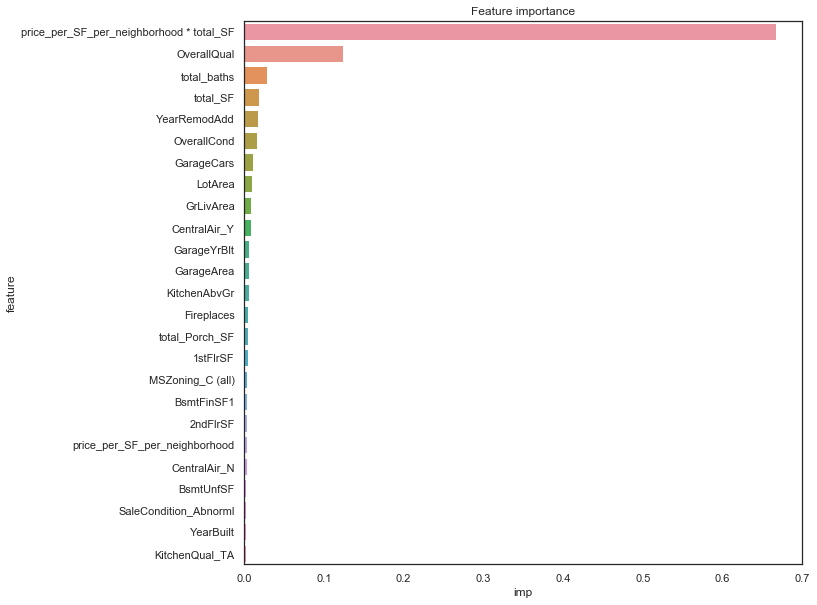

In [38]:
if hasattr(bestFit, 'feature_importances_'):
    plot_feature_importance(X_train, y_train, bestFit)

<a id='part_6'></a>
# Part 6: Make Prediction for the Test Data
* Predict the data in the "test.csv" file using the best fitted model

In [39]:
X_test = X_full.loc[X_full['isTest'] == 1]
X_test = X_test[featuresToSelect]
X_test_scaled = scaler.transform(X_test.astype(np.float64))

In [40]:
y_pred = np.expm1(bestFit.predict(X_test_scaled))

# Make sure there are no negative predicted values
min_value = np.min(y_train_orig)
y_pred = [i if i>0 else min_value for i in y_pred]

In [41]:
resultsDf = pd.DataFrame({'Id': X_test.index, TARGET_COLUMN: y_pred})
resultsDf.to_csv('House_Prices_Submission.csv', index=False)